In [2]:
import math
import numpy as np

from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator, BackendSamplerV2 as BackendSampler
from qiskit.providers.basic_provider import BasicProvider 
from qiskit.primitives import StatevectorEstimator, StatevectorSampler

import math
pi=math.pi

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':12})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
def X(qc,q,theta):
    """
    exp(-i*theta*X)
    """
    qc.rx(2*theta,q)
        
def Z(qc,q,theta):
    """
    exp(-i*theta*Z)
    """
    qc.rz(2*theta,q)
        
def ZZ(qc,q0,q1,theta):
    """
    exp(-i*theta*Z0*Z1)
    """
    qc.cx(q1,q0)
    qc.rz(2*theta,q0)
    qc.cx(q1,q0)
        
def XZ(qc,q0,q1,theta):
    """
    exp(-i*theta*X0*Z1)
    """
    qc.h(q0)
    qc.cx(q1,q0)
    qc.rz(2*theta,q0)
    qc.cx(q1,q0)
    qc.h(q0)
    
    
def XZZ(qc,q0,q1,q2,theta):
    """
    exp(-i*theta*X0*Z1*Z2)
    """
    qc.h(q0)
    qc.cx(q1,q0)
    qc.cx(q2,q0)
    qc.rz(2*theta,q0)
    qc.cx(q2,q0)
    qc.cx(q1,q0)
    qc.h(q0)
        

In [4]:
def H(qc,q,dt):
    """
    exp(-i*dt*H)
    """
    N = len(q)    
    theta = (1/4)*dt
    
    for i in range(1,N-1):
        X(qc,q[i],theta)
        XZZ(qc,q[i],q[i-1],q[i+1],theta)
        XZ(qc,q[i],q[i+1],theta)
        XZ(qc,q[i],q[i-1],theta)


In [5]:
def Neel(qc,q):
    N = len(q)    
    
    for i in range(1,N,2):
        qc.x(q[i])

In [12]:
def cswap(qc,q0,q1,q2):
    N = len(q1)

    for i in range(N//2):
        qc.cswap(q0,q1[i],q2[i])

## Measure Fidelity

In [7]:
N=8
T=5
dt=0.05
M=int(T/dt)
times = np.arange(M)
shots=1024

backend = BasicSimulator()

fidelity = []
for time in times:

    q = QuantumRegister(N,"q")
    c = ClassicalRegister(N,"c")
    qc = QuantumCircuit(q,c)
    
    for _ in range(time):
        H(qc,q,dt)
    
    qc.measure(q,c)

    sampler= BackendSampler(backend=backend)
    result = sampler.run([(qc)],shots=shots).result()[0].data.c
    
    counts = result.get_counts()
        
    r1=list(counts.keys())
    
    if np.any(np.array(r1)=="0"*N):
        fidelity.append(counts["0"*N]/shots)
    else:
        fidelity.append(0)

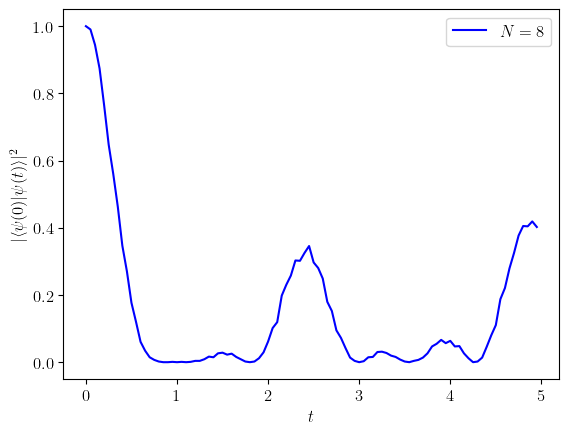

In [8]:
times = np.arange(int(T/dt))
plt.plot(dt*times,fidelity,'b-',label=r"$N=8$")
plt.xlabel("$t$")
plt.ylabel(r"$|\langle \psi(0)|\psi(t)\rangle|^2$")
plt.legend()
plt.show()

In [9]:
N=8
T=5
dt=0.05
M=int(T/dt)
times = np.arange(M)

backend = BasicSimulator()
shots = 1024 # irrelevant for snapshot

fidelity2 = []
for time in times:

    q = QuantumRegister(N,"q")
    c = ClassicalRegister(N,"c")
    qc = QuantumCircuit(q,c)
    
    Neel(qc,q)
    
    for _ in range(time):
        H(qc,q,dt)
    
    qc.measure(q,c)
    
    sampler= BackendSampler(backend=backend)
    result = sampler.run([(qc)],shots=shots).result()[0].data.c
    
    counts = result.get_counts()
    
    r1=np.array(list(counts.keys()))
    
    if np.any(r1=="10"*(N//2)):
        fidelity2.append(counts["10"*(N//2)]/shots)
    else:
        fidelity2.append(0)

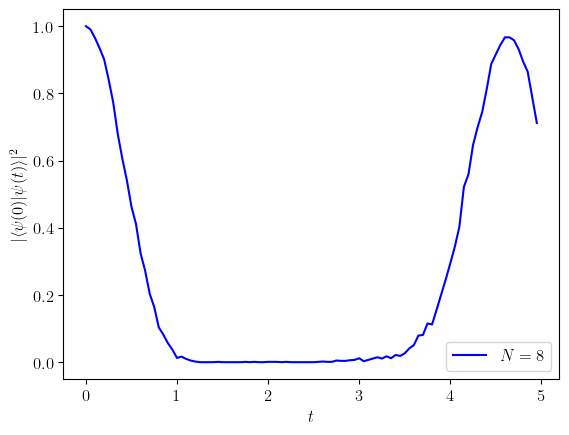

In [10]:
times = np.arange(int(T/dt))
plt.plot(dt*times,fidelity2,'b-',label=r"$N=8$")
plt.xlabel("$t$")
plt.ylabel(r"$|\langle \psi(0)|\psi(t)\rangle|^2$")
plt.legend()
plt.show()

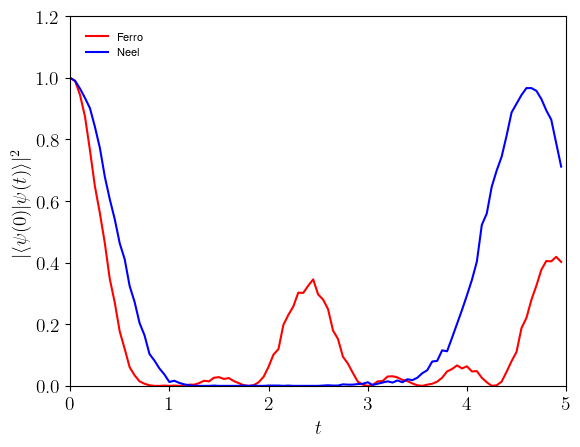

In [11]:
times = np.arange(int(T/dt))
plt.plot(dt*times,fidelity,'r-',label="Ferro")
plt.plot(dt*times,fidelity2,'b-',label="Neel")

plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$|\langle\psi(0)|\psi(t)\rangle|^2$", fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim([0.,T])
plt.ylim([0.,1.20])
legend =plt.legend(bbox_to_anchor=(0, 1.0), loc='upper left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()

## Measure Renyi2

In [15]:
N=6
T=5
dt=0.05
M=int(T/dt)
times = np.arange(M)

backend = BasicSimulator()

S= np.zeros(len(times))
Serr= np.zeros(len(times))

for time in times:

    q0 = QuantumRegister(1,"q0")
    q1 = QuantumRegister(N,"q1")
    q2 = QuantumRegister(N,"q2")
    qc = QuantumCircuit(q0,q1,q2)

    qc.h(q0)
    
    for _ in range(time):
        H(qc,q1,dt)

    for _ in range(time):
        H(qc,q2,dt)

    cswap(qc,q0,q1,q2) 

    op= [('X' ,[0],1.0)]
    op=SparsePauliOp.from_sparse_list(op , num_qubits=1+2*len(q1))

    estimator= BackendEstimator(backend=backend)
    result = estimator.run([(qc,op)]).result()[0].data
    S[time]=-np.log(result.evs)
    Serr[time]=result.stds/result.evs


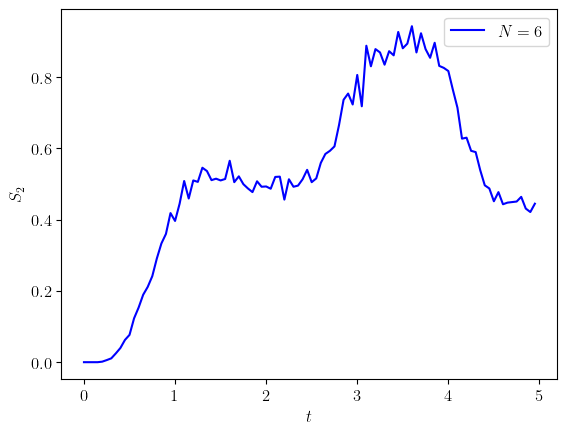

In [21]:
times = np.arange(int(T/dt))
plt.plot(dt*times,S,'b-',label=r"$N=6$")
plt.xlabel("$t$")
plt.ylabel(r"$S_2$")
plt.legend()
plt.show()

In [17]:
N=6
T=5
dt=0.05
M=int(T/dt)
times = np.arange(M)

backend = BasicSimulator()

S2= np.zeros(len(times))
Serr2= np.zeros(len(times))

for time in times:

    q0 = QuantumRegister(1,"q0")
    q1 = QuantumRegister(N,"q1")
    q2 = QuantumRegister(N,"q2")
    qc = QuantumCircuit(q0,q1,q2)

    qc.h(q0)
    Neel(qc,q1)
    Neel(qc,q2)
    
    for _ in range(time):
        H(qc,q1,dt)

    for _ in range(time):
        H(qc,q2,dt)

    cswap(qc,q0,q1,q2) 

    op= [('X' ,[0],1.0)]
    op=SparsePauliOp.from_sparse_list(op , num_qubits=1+2*len(q1))

    estimator= BackendEstimator(backend=backend)
    result = estimator.run([(qc,op)]).result()[0].data
    S2[time]=-np.log(result.evs)
    Serr2[time]=result.stds/result.evs


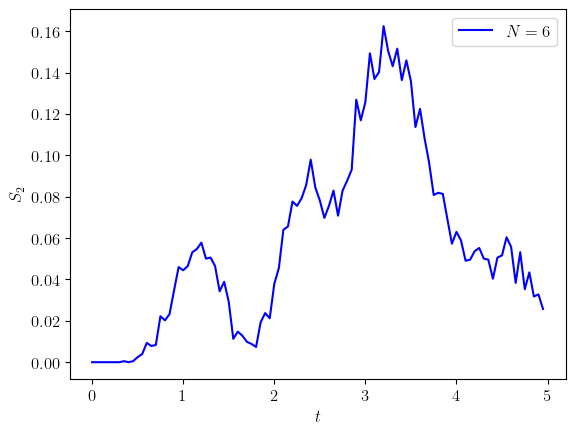

In [23]:
times = np.arange(int(T/dt))
plt.plot(dt*times,S2,'b-',label=r"$N=6$")
plt.xlabel("$t$")
plt.ylabel(r"$S_2$")
plt.legend()
plt.show()

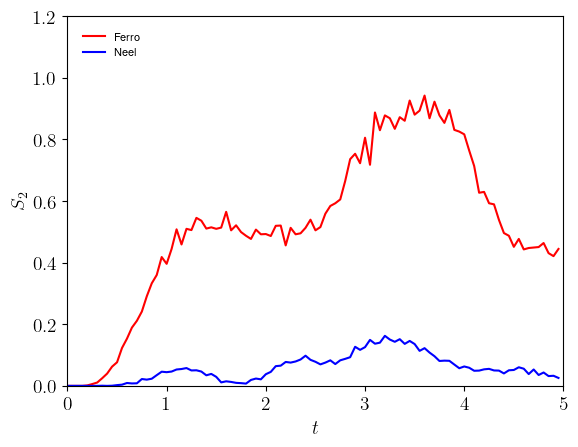

In [24]:
times = np.arange(int(T/dt))
plt.plot(dt*times,S,'r-',label="Ferro")
plt.plot(dt*times,S2,'b-',label="Neel")

plt.xlabel(r"$t$", fontsize=14)
plt.ylabel(r"$S_2$", fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim([0.,T])
plt.ylim([0.,1.20])
legend =plt.legend(bbox_to_anchor=(0, 1.0), loc='upper left', borderaxespad=1, fontsize=8)
frame = legend.get_frame()
frame.set_linewidth(0)
plt.show()